In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, auc

In [2]:
"""
    find_header_row(filename, search_term)

read in excel file and check first ten rows for search term. 
return the first row in which the search term appears
"""
def find_header_row(filename, search_term='Time'):

    for i in range(10):  # Check first 10 rows
        df = pd.read_excel(filename, header=i, nrows=1)
        if search_term in df.columns or 's' in df.columns:
            return i
        
    return None  # If header not found

"""
    read_data(cof, gas, carrier, ppm)

read in the sensor response data for a given COF exposed to a 
given gas with a given carrier at a given concentration.
returns list of pandas data frames with this data. (may be replicates)
each data frame has two columns: time, DeltaG/G0.
"""
def read_data(cof, gas, carrier, ppm):

    # get path to appropriate file
    path = Path.cwd().joinpath("Raw_sensing_data", gas, cof, carrier,).rglob("*.xlsx")

    # some folders contain multiple excel files, so create a list
    files = [file for file in path]
        
    # extract data from Excel files in list
    dfs = []
    for filename in files:
        # CASE 1: all replicates in a single file.
        #if len(files) == 1:
        header_row = find_header_row(filename)
    
        if header_row is not None:
            df = pd.read_excel(filename, 
                           header=header_row)
        else:
            
            break

        df = df.loc[1500:6660, df.columns[df.columns.str.contains('Go',na=False) | (df.columns=='s') | (df.columns=='Time')]]
        if 'Time' in df.columns:
            df = df.rename(columns={"Time": "s"})
        # exposure time begins at 750s
        # exposure time ends 2580s later (3330s)
       
        assert df.iloc[0]["s"] == 750.0
        assert df.iloc[-1]["s"] == 3330.0

        # drop columns with missing values
        df = df.dropna(axis='columns')

        # reshift time
        df["s"] = df["s"] - 750.0

        df.reset_index(drop=True, inplace=True)

        # separate replicates into differente dataframes and append to dfs
        for i in df.columns:
            if 'G' in i and not np.all(df[i] == 100.0):
                data_rep = df[['s',i]]
                data_rep = data_rep.rename(columns={i: "ΔG/G0"})
                dfs.append(data_rep)
                 
    return dfs

In [3]:
data = read_data("Cu-COF-DC-8", "NH3", "N2_dry", 80)
data

[           s      ΔG/G0
 0        0.0  26.785053
 1        0.5  26.785053
 2        1.0  26.785053
 3        1.5  26.962292
 4        2.0  27.139672
 ...      ...        ...
 5156  2578.0  42.660767
 5157  2578.5  42.660767
 5158  2579.0  42.660767
 5159  2579.5  42.660767
 5160  2580.0  42.660767
 
 [5161 rows x 2 columns],
            s      ΔG/G0
 0        0.0  24.694358
 1        0.5  24.694358
 2        1.0  24.823385
 3        1.5  24.823385
 4        2.0  24.952001
 ...      ...        ...
 5156  2578.0  39.485333
 5157  2578.5  39.485333
 5158  2579.0  39.485333
 5159  2579.5  39.742975
 5160  2580.0  39.742975
 
 [5161 rows x 2 columns],
            s      ΔG/G0
 0        0.0  27.888909
 1        0.5  27.888909
 2        1.0  27.888909
 3        1.5  27.888909
 4        2.0  28.079623
 ...      ...        ...
 5156  2578.0  34.383586
 5157  2578.5  34.574301
 5158  2579.0  34.383586
 5159  2579.5  34.383586
 5160  2580.0  34.383586
 
 [5161 rows x 2 columns],
            s   

In [4]:
data1 = read_data("Cu-COF-DC-8", "H2S", "air_humid", 80)
data1

[           s      ΔG/G0
 0        0.0   0.000000
 1        0.5   0.000000
 2        1.0  -0.217382
 3        1.5   0.000000
 4        2.0  -0.217382
 ...      ...        ...
 5156  2578.0  89.236542
 5157  2578.5  89.247393
 5158  2579.0  89.253904
 5159  2579.5  89.228954
 5160  2580.0  89.224613
 
 [5161 rows x 2 columns],
            s      ΔG/G0
 0        0.0  -0.064974
 1        0.5   0.000000
 2        1.0  -0.043201
 3        1.5   0.237430
 4        2.0   0.129602
 ...      ...        ...
 5156  2578.0  99.015552
 5157  2578.5  99.019223
 5158  2579.0  99.017495
 5159  2579.5  99.022464
 5160  2580.0  99.023543
 
 [5161 rows x 2 columns],
            s      ΔG/G0
 0        0.0   0.140033
 1        0.5   0.419539
 2        1.0   0.489331
 3        1.5   0.279730
 4        2.0   0.140033
 ...      ...        ...
 5156  2578.0  98.150651
 5157  2578.5  98.145059
 5158  2579.0  98.149947
 5159  2579.5  98.147151
 5160  2580.0  98.147151
 
 [5161 rows x 2 columns],
            s   

In [5]:
data[0]

,s,ΔG/G0
0,0.0,26.785053
1,0.5,26.785053
2,1.0,26.785053
3,1.5,26.962292
4,2.0,27.139672
...,...,...
5156,2578.0,42.660767
5157,2578.5,42.660767
5158,2579.0,42.660767
5159,2579.5,42.660767


In [6]:
"""
    lin_reg(df)
    perform linear regression on a single partition of data
    arguments:
    * df := dataframe of a single partition of sensor_response data
    * ids_split := indices of response data partition
    output: list of the following arguments
    * coef := coefficient from linear regression
    * mse := mean squared error of linear regression
    * y_fit := y values fit to the X,Y data
    * ids_split
"""
def lin_reg(df,ids_split):
    X = df.loc[:,"s"].to_numpy().reshape(-1,1)
    Y = df.loc[:,"ΔG/G0"].to_numpy().reshape(-1,1)
    reg = LinearRegression().fit(X,Y)
    y_fit = reg.predict(X)
    mse = mean_squared_error(Y,y_fit)

    coef = reg.coef_.tolist().pop().pop()

    return [coef,mse,y_fit,ids_split]

In [34]:
class SensorResponse:
    def __init__(self, cof, gas, carrier_gas, ppm, replicate_id):
        self.cof = cof
        self.gas = gas
        self.carrier_gas = carrier_gas
        self.ppm = ppm

        try:
            self.data = read_data(cof, gas, carrier_gas, ppm)[replicate_id]
        except IndexError:
            print(f"Error: replicate_id {replicate_id} does not exist in the data.")
        
    """
    compute_initial_slope(self, partition_size, total_time_window, mse_bound)
    estimate initial slope of data.

      arguments:
     * partition_size := size of the time window for partitions (ex: 30sec)
     * total_time_window := the total time after introduction of substance
     * considered to compute intial slope (ex: 1000s)
     * mse_bound := bound on acceptable mean squared error for initial slope linear regression
    """
    def compute_initial_slope(self, n_partitions = 100, total_time_window=600, mse_bound=1):

        # partition data indices
        ids_splits = np.array_split(self.data.index, n_partitions)
        # create list of regression on each partition of data which satisfy the mean_squared error bound
        regression_data = [lin_reg(self.data.iloc[ids_split],ids_split) for ids_split in ids_splits 
                           if lin_reg(self.data.iloc[ids_split],ids_split)[1] < mse_bound]
                
        if bool(regression_data) == 0:
            print("Data has no initial slopes that satisfy mse bound.")  
            return      

        # find index of max absolute value of linear regression coefficients
        arr = np.array(regression_data)
        id_initial_slope = np.argmax(np.abs(arr.T[0]))

        # return regression_data which contains the initial slope 
        return regression_data[id_initial_slope]

    def compute_saturation(self, n_partitions=100):
        ids_splits = np.array_split(self.data.index, n_partitions)

        # get mean over partitions
        means = [np.mean(self.data.iloc[ids_split]['ΔG/G0']) for ids_split in ids_splits]

        id_max_magnitude = np.argmax(np.abs(means))
        
        return means[id_max_magnitude]
    
    #compute area under curve for each GBx DeltaG/G0 using sklearn auc
    # def compute_area(self,k=0):
    #     X = self.data[k].loc[:,'time'].to_numpy().reshape(-1,1)
    #     Y1 = self.data[k].loc[:,'GB1 DeltaG/G0'].to_numpy().reshape(-1,1)
    #     Y2 = self.data[k].loc[:,'GB2 DeltaG/G0'].to_numpy().reshape(-1,1)
    #     Y3 = self.data[k].loc[:,'GB3 DeltaG/G0'].to_numpy().reshape(-1,1)
    #     Y4 = self.data[k].loc[:,'GB4 DeltaG/G0'].to_numpy().reshape(-1,1)

    #     areas = [auc(X,Y1),auc(X,Y2),auc(X,Y3),auc(X,Y4)]
    #     return areas
    
    def viz(self, save=False): # viz the data along with the response features or function u fit to it.
        
        # sat = self.compute_saturation()
        fig, ax = plt.subplots()
        plt.scatter(self.data['s'], self.data['ΔG/G0'])
        plt.xlabel("time [s]")
        plt.ylabel("$\Delta G/G_0$")
        

        initial_slope = self.compute_initial_slope()
        plt.scatter(self.data.loc[initial_slope[3], 's'], self.data.loc[initial_slope[3], 'ΔG/G0'])
        plt.plot(self.data.loc[initial_slope[3], 's'], initial_slope[2], color='orange')
        # create inset axes & plot initial slope data on them
        ins_ax = fig.add_axes([0.6,0.2,0.3,0.3])
        ins_ax.scatter(self.data.loc[initial_slope[3], 's'], self.data.loc[initial_slope[3], 'ΔG/G0'])
        ins_ax.plot(self.data.loc[initial_slope[3], 's'], initial_slope[2], color = 'orange')

        plt.show()
        
        
    # def vector_representation(self,docnum=0): # returns the vector characterizing the response.
    #     response = []
    #     response.append(self.compute_initial_slope(k=docnum)[0])
    #     response.append(self.compute_saturation(k=docnum))
    #     response.append(self.compute_area(k=docnum))
    #     return response

In [35]:
# Test the SensorResponse class initial_slope function
sensor_response = SensorResponse("Cu-COF-DC-8", "H2S", "air_humid", 80, 1)

C:\Users\nik20\AppData\Local\Temp\ipykernel_13412\3087116477.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(regression_data)


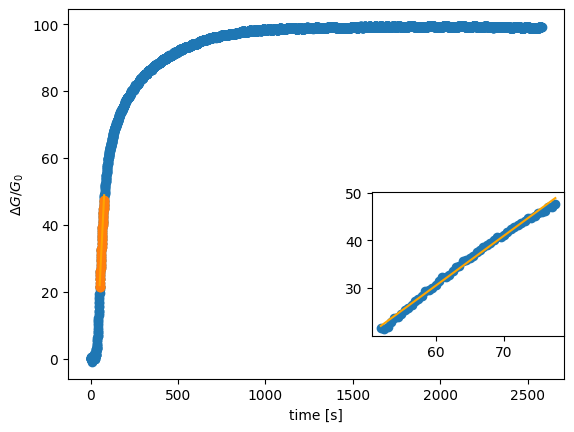

In [36]:
sensor_response.viz()

In [ ]:
sensor_response.compute_saturation()

99.40638770818612

In [ ]:
np.array_split(sensor_response.data.index, 3)

[Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720],
            dtype='int64', length=1721),
 Int64Index([1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730,
             ...
             3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440],
            dtype='int64', length=1720),
 Int64Index([3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450,
             ...
             5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160],
            dtype='int64', length=1720)]

In [ ]:
test.viz()

NameError: name 'test' is not defined

In [ ]:
print(test.compute_initial_slope(20,600,0,0.1)[0])
print(test.compute_saturation())
print(test.compute_area())

[1.9361849675693334, 1.5482583343604446, 1.2051431400306394, 1.4838288917660671]
[98.56822400886834, 99.62978386578861, 99.40344396050958, 98.17446517362984]
[241723.8886419699, 244152.272025501, 243007.23352050892, 239705.57772069253]


In [ ]:
print(test.vector_representation())

[[0.4392201924419994, 1.3430418427765265, 1.1194797316220995, 0.5289642577599905], [98.56822400886834, 99.62978386578861, 99.40344396050958, 98.17446517362984], [241723.8886419699, 244152.272025501, 243007.23352050892, 239705.57772069253]]


In [ ]:
test2 = SensorResponse("Cu-COF-DC-8","NH3","air_humid",80)

In [ ]:
print(test2.compute_initial_slope()[0])
print(test2.compute_saturation())
print(test2.compute_area())


[0.5146028187993581, 0.4502340714437489, 0.0, 0.0]
[65.30217906998811, 52.71640927978379, 100.0, 100.0]
[143523.8119352084, 115758.26203188971, 258000.0, 258000.0]


In [ ]:
print(test2.vector_representation())

[[0.5146028187993581, 0.4502340714437489, 0.0, 0.0], [65.30217906998811, 52.71640927978379, 100.0, 100.0], [143523.8119352084, 115758.26203188971, 258000.0, 258000.0]]


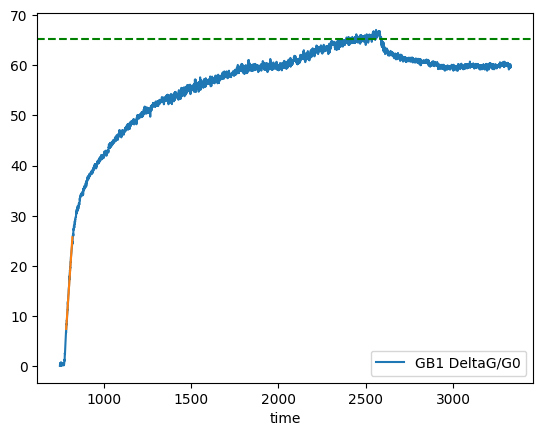

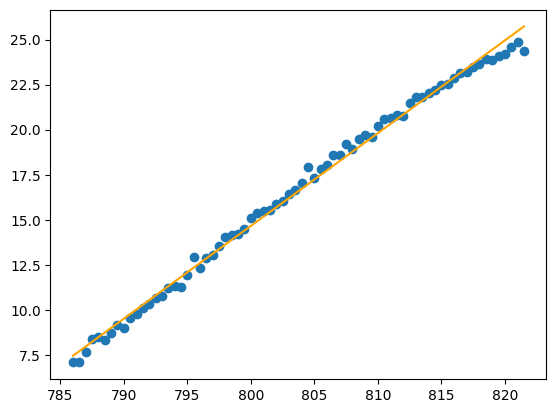

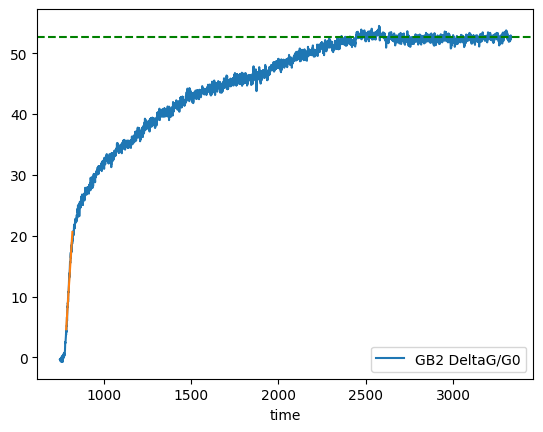

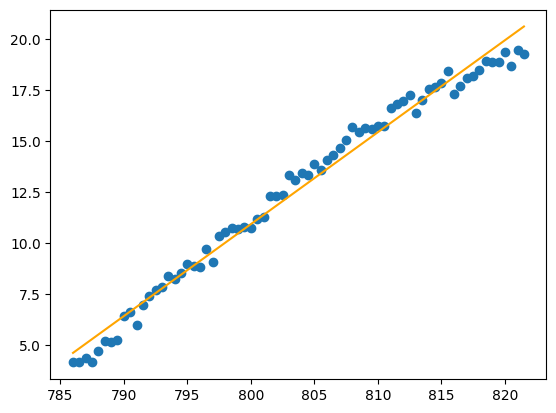

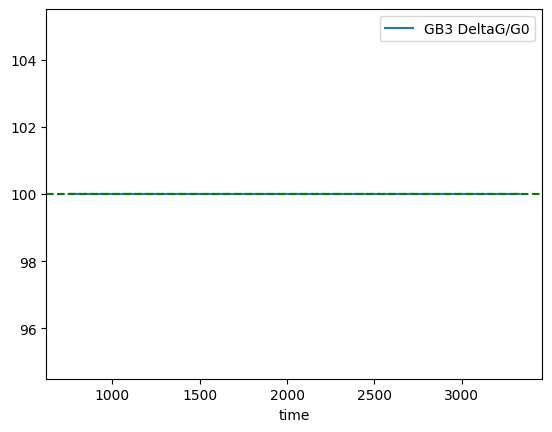

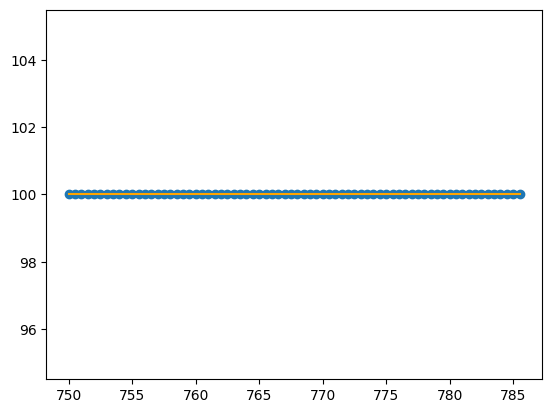

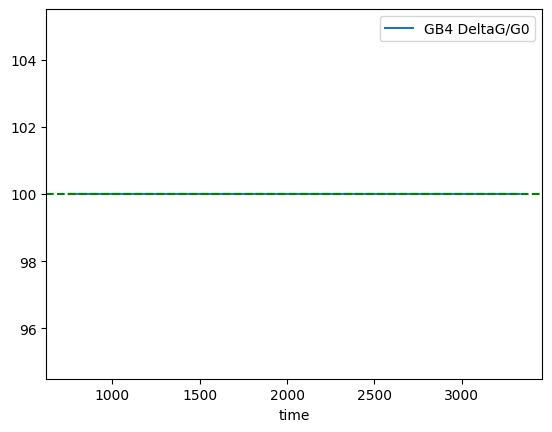

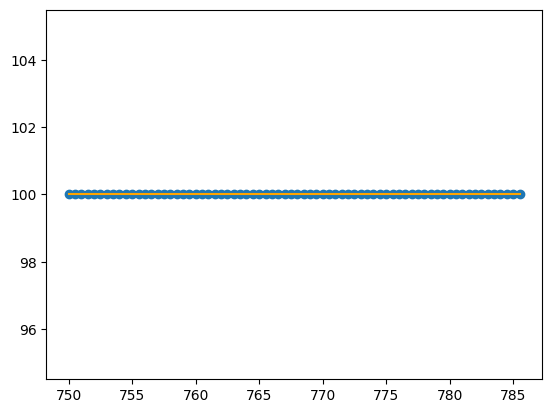

In [ ]:
test2.viz()

In [ ]:
test3 = SensorResponse("Co-COF-DC-8","NH3","air_dry",80)

[[0.1403905363598618, 0.11854736836344731, 0.22305019135829915, 0.17223453040267767], [33.93481926319436, 30.713947700145944, 41.83887502439708, 37.63004886826016], [60568.30496689379, 52393.08446885612, 78917.74553888658, 68161.19706790437]]


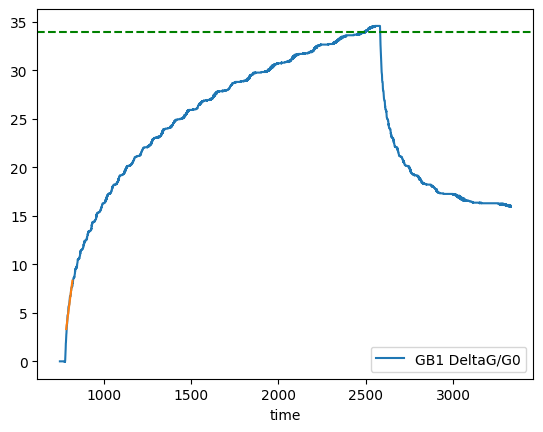

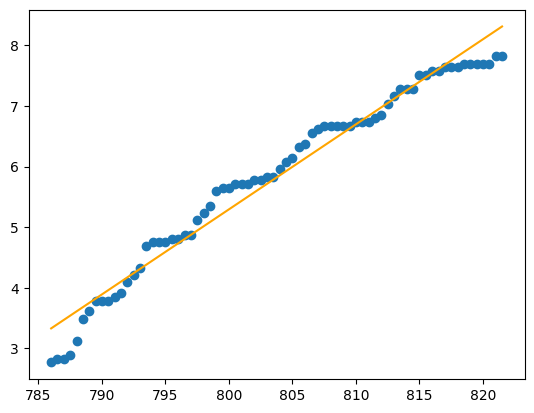

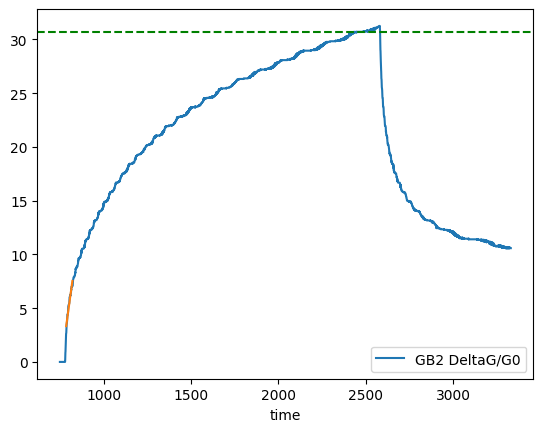

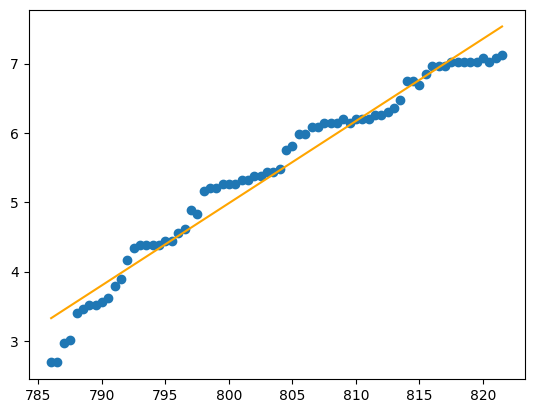

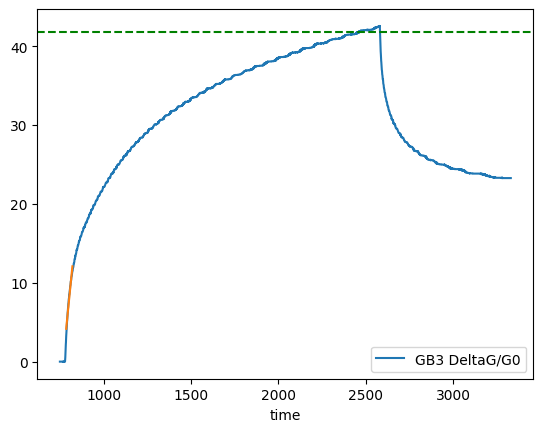

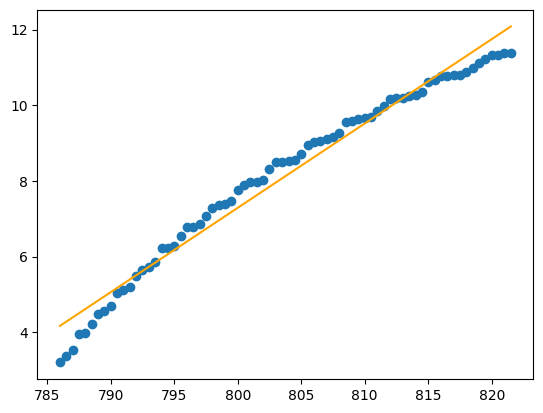

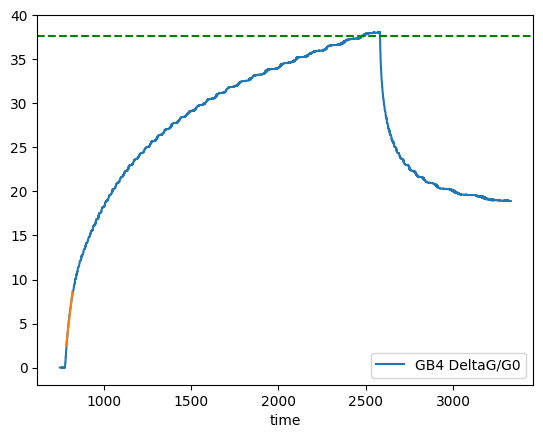

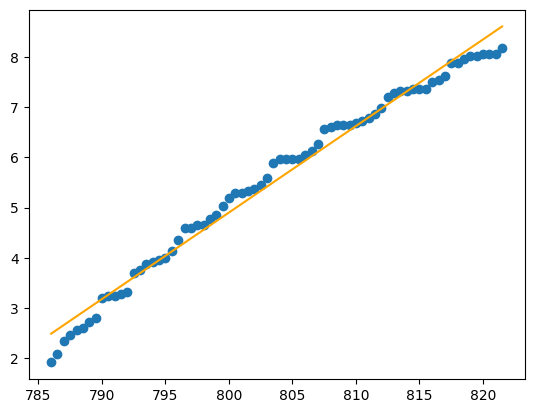

In [ ]:
print(test3.vector_representation())
test3.viz()

In [ ]:
test4 = SensorResponse("Co-COF-DC-8","NO","air_dry",80)

[[1.3065132295852573, 1.5409178228161564, 1.2308772238709558, 0.0], [-183.20928518122406, -255.0613768923525, -178.97288218914343, 100.0], [-403546.2003406406, -549183.0763421704, -389965.97295681835, 258000.0]]


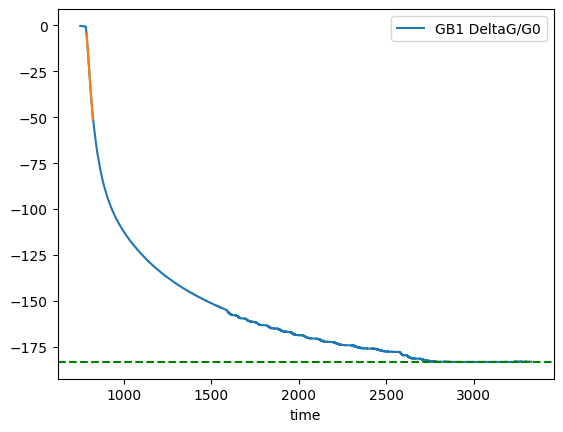

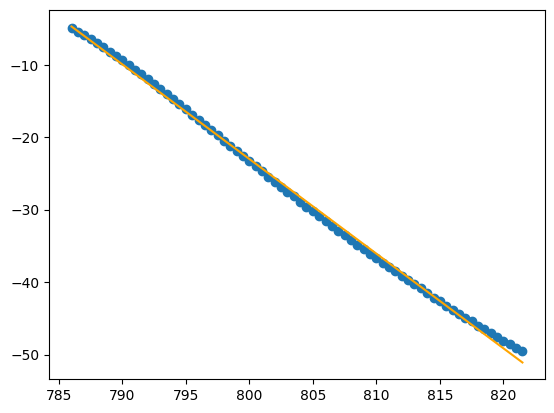

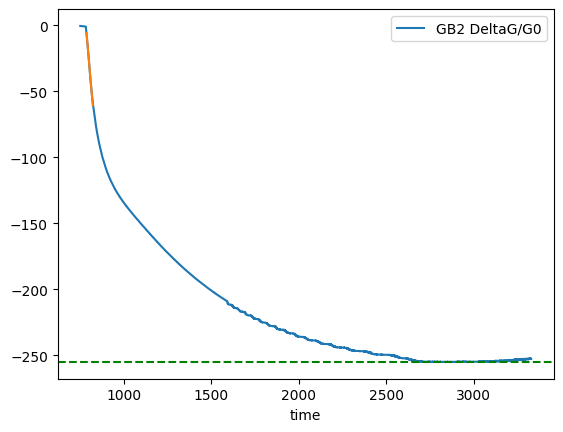

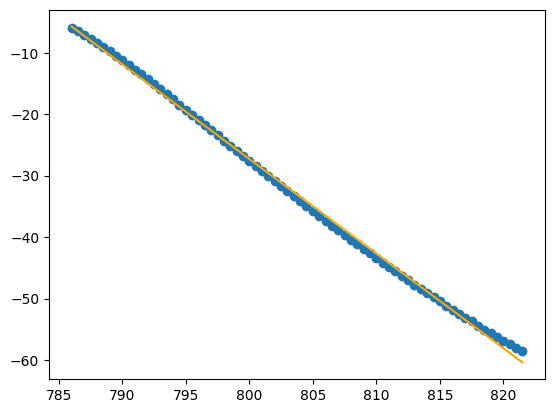

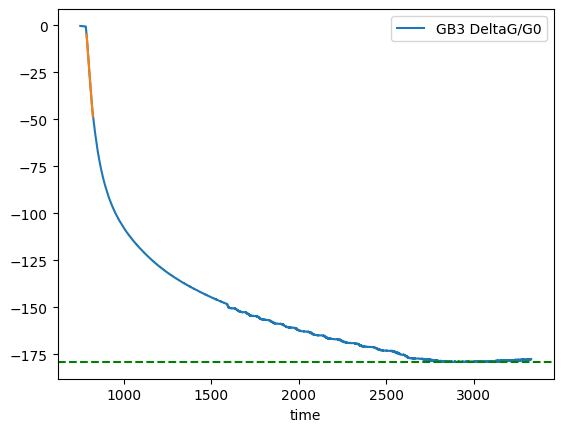

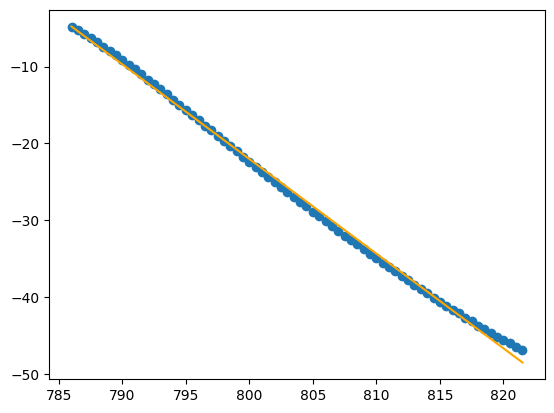

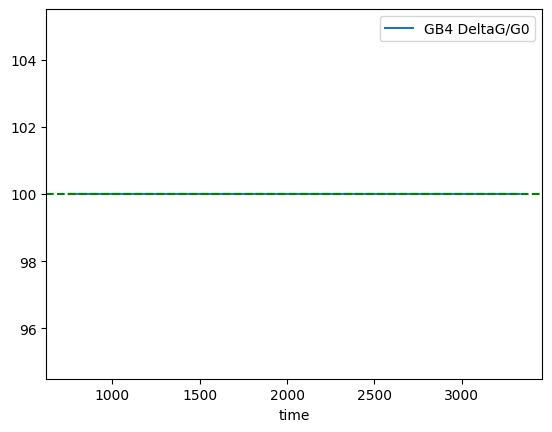

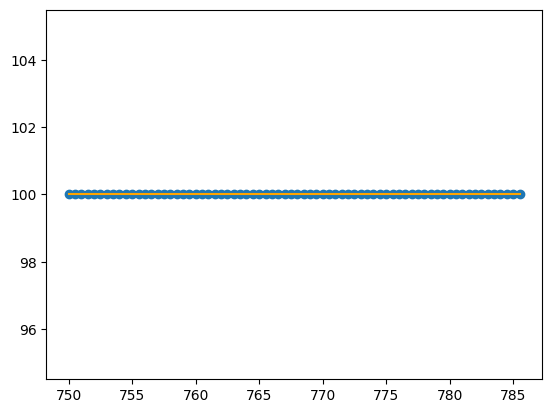

In [ ]:
print(test4.vector_representation())
test4.viz()